In [ ]:
# 1. Install Dependencies
import subprocess
try:
    import ultralytics
    import timm
    import transformers
except ImportError:
    print("Installing YOLO, Timm, and Transformers...")
    subprocess.check_call(["pip", "install", "ultralytics", "timm", "transformers", "scipy", "-q"])

import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
import timm
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
from google.colab import drive, files
import os
from transformers import CLIPProcessor, CLIPModel

In [ ]:
# 2. Setup Device & Paths
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using Device: {device}")

drive.mount('/content/drive')

# --- CONFIGURATION ---
METADATA_PATH = "/content/drive/MyDrive/Cars/misc/make_model_name.mat"
WEIGHTS_PATH = "/content/drive/MyDrive/compcars_best_model.pth"
# ---------------------

Using Device: cpu
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 3. Load Metadata
if os.path.exists(METADATA_PATH):
    mat = sio.loadmat(METADATA_PATH)
    make_names = [x[0] for x in mat['make_names']]
    model_names = [x[0] for x in mat['model_names']]
    num_makes = len(make_names)
    num_models = len(model_names)
else:
    raise FileNotFoundError(f"❌ Metadata not found at {METADATA_PATH}")

In [ ]:
# 4. Load Models

# A. YOLOv8 (The Spotter)
print("Loading YOLOv8...")
detector = YOLO('yolov8n.pt')

# B. CLIP (The Color Expert)
# We use a lightweight version of CLIP for speed
print("Loading CLIP (Color Expert)...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
print("✅ CLIP Ready.")

# C. EfficientNet (The Make/Model Expert)
class CarClassifier(nn.Module):
    def __init__(self, num_makes, num_models):
        super().__init__()
        self.backbone = timm.create_model("tf_efficientnetv2_s", pretrained=False, num_classes=0)
        feat_dim = self.backbone.num_features
        self.make_head  = nn.Linear(feat_dim, num_makes)
        self.model_head = nn.Linear(feat_dim, num_models)

    def forward(self, x):
        f = self.backbone(x)
        return self.make_head(f), self.model_head(f)

classifier = CarClassifier(num_makes, num_models).to(device)

if os.path.exists(WEIGHTS_PATH):
    if device == 'cpu':
        state_dict = torch.load(WEIGHTS_PATH, map_location=torch.device('cpu'))
    else:
        state_dict = torch.load(WEIGHTS_PATH)
    classifier.load_state_dict(state_dict)
    classifier.eval()
    print("✅ Classifier Weights Loaded.")
else:
    raise FileNotFoundError(f"❌ Weights not found at {WEIGHTS_PATH}")

Loading YOLOv8...
Loading CLIP (Color Expert)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

✅ CLIP Ready.
✅ Classifier Weights Loaded.


In [ ]:
# 5. Logic Helpers

clf_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def get_clip_color(image):
    """
    Uses CLIP to compare the image against text descriptions of car colors.
    """
    # Define the choices we want CLIP to choose from
    colors = [
        "black", "white", "silver", "grey", "red",
        "blue", "green", "yellow", "orange", "brown", "beige", "gold"
    ]
    # We construct sentences so CLIP understands the context
    text_prompts = [f"a photo of a {c} car" for c in colors]

    # Process inputs
    inputs = clip_processor(
        text=text_prompts,
        images=image,
        return_tensors="pt",
        padding=True
    ).to(device)

    # Run Inference
    with torch.no_grad():
        outputs = clip_model(**inputs)
        # Calculate similarity logits and softmax them to get percentages
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)

    # Get top prediction
    top_prob, top_idx = probs.topk(1, dim=1)
    detected_color = colors[top_idx.item()]
    confidence = top_prob.item()

    return detected_color.capitalize(), confidence

def unnormalize(tensor):
    tensor = tensor.clone().detach().cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    return tensor.clamp(0, 1).permute(1, 2, 0)

def predict_car(image_path):
    # --- STAGE 1: DETECTION ---
    try:
        original_img = Image.open(image_path).convert("RGB")
    except:
        return

    results = detector(original_img, verbose=False)

    best_box = None
    best_conf = 0.0
    vehicle_classes = [2, 5, 7]

    for result in results:
        for box in result.boxes:
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            if cls_id in vehicle_classes and conf > best_conf:
                best_conf = conf
                best_box = box.xyxy[0].cpu().numpy()

    if best_box is not None:
        x1, y1, x2, y2 = map(int, best_box)
        margin_w = (x2 - x1) * 0.05
        margin_h = (y2 - y1) * 0.05
        x1 = max(0, int(x1 - margin_w))
        y1 = max(0, int(y1 - margin_h))
        x2 = min(original_img.width, int(x2 + margin_w))
        y2 = min(original_img.height, int(y2 + margin_h))

        car_crop = original_img.crop((x1, y1, x2, y2))
        status = "✅ Found Car"

        # --- NEW: CLIP COLOR DETECTION ---
        detected_color, color_conf = get_clip_color(car_crop)
        # ---------------------------------

    else:
        car_crop = original_img
        status = "⚠️ No Detection"
        detected_color = "Unknown"
        color_conf = 0.0

    # --- STAGE 2: CLASSIFICATION ---
    input_tensor = clf_transform(car_crop).unsqueeze(0).to(device)

    with torch.no_grad():
        out_make, out_model = classifier(input_tensor)
        prob_make = torch.softmax(out_make, dim=1)
        prob_model = torch.softmax(out_model, dim=1)

        top_make_probs, top_make_idxs = prob_make.topk(3, dim=1)
        top_model_probs, top_model_idxs = prob_model.topk(3, dim=1)

    # --- VISUALIZATION ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(original_img)
    if best_box is not None:
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=3)
        ax[0].add_patch(rect)

    # Display CLIP result in the title
    ax[0].set_title(f"Detection: {status}\nColor: {detected_color} ({color_conf:.1%})", fontsize=12, fontweight='bold')
    ax[0].axis('off')

    model_view = unnormalize(input_tensor[0])
    ax[1].imshow(model_view)
    ax[1].set_title("Classifier Input", color='blue')
    ax[1].axis('off')

    plt.show()

    # --- RESULTS ---
    print(f"\n🎨 COLOR EXPERT SAYS: {detected_color.upper()} ({color_conf:.1%} confidence)")
    print("-" * 50)
    print("🏆 MAKE/MODEL PREDICTIONS")
    print("-" * 50)
    for i in range(3):
        mk_idx = top_make_idxs[0][i].item()
        mk_prob = top_make_probs[0][i].item()
        m_idx = top_model_idxs[0][i].item()
        m_prob = top_model_probs[0][i].item()

        pred_make = make_names[mk_idx]
        pred_model = model_names[m_idx]

        print(f"{i+1}. {pred_make} {pred_model}")
        print(f"   (Make Conf: {mk_prob:.1%}, Model Conf: {m_prob:.1%})")
    print("-" * 50)

Upload a photo to test:


Saving WhatsApp Image 2025-11-22 at 10.58.17 PM.jpeg to WhatsApp Image 2025-11-22 at 10.58.17 PM (1).jpeg


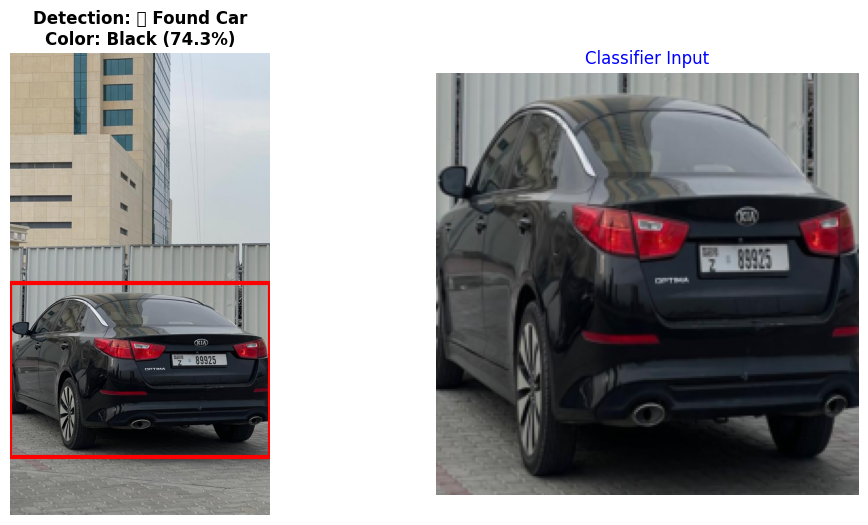


🎨 COLOR EXPERT SAYS: BLACK (74.3% confidence)
--------------------------------------------------
🏆 MAKE/MODEL PREDICTIONS
--------------------------------------------------
1. ['KIA'] ['KIA K5']
   (Make Conf: 100.0%, Model Conf: 99.9%)
2. ['Hyundai '] ['SPORTAGE']
   (Make Conf: 0.0%, Model Conf: 0.1%)
3. ['Besturn'] ['Legacy']
   (Make Conf: 0.0%, Model Conf: 0.0%)
--------------------------------------------------


In [ ]:
# 6. Run User Upload
print("Upload a photo to test:")
uploaded = files.upload()

for filename in uploaded.keys():
    predict_car(filename)